# Utilizando um modelo de Random Forest para prever a quantidade de bicicletas alugadas em um serviço de aluguel de bicicletas

* O objetivo desse projeto é prever a quantidade de bicicletas alugadas em um serviço de aluguel de bicicletas urbanas. 

* O dataset utilizado pode ser baixado no seguinte link: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset 

* Esse projeto foi desenvolvido por mim como parte do curso de **"Machine Learning Introduction" do Dataquest**, um site americano que oferece cursos pagos de ciência de dados. O Dataquest oferece **projetos guiados** ao término de cada módulo, onde os alunos aplicam os conceitos aprendidos no módulo. Nos projetos guiados são utilizados datasets reais e os alunos recebem instruções gerais de como resolver o problema proposto. O site oferece a "solução" para cada projeto guiado, que pode ser encontrada no seguinte link https://github.com/dataquestio/solutions/blob/master/Mission213Solution.ipynb . Fiz diversas melhorias em relação à solução apresentada pelo site, como plotar a árvore de decisão e identificar features categóricas.

* O dataset possui 17 mil linhas e suas colunas estão descritas abaixo, o valor que buscamos estimar através de nossos modelos é o valor da coluna 'cnt' que apresenta a quantidade de bicicletas alugadas em determinada hora.

  * instant - A unique sequential ID number for each row
  * dteday - The date of the rentals
  * season - The season in which the rentals occurred
  * yr - The year the rentals occurred
  * mnth - The month the rentals occurred
  * hr - The hour the rentals occurred
  * holiday - Whether or not the day was a holiday
  * weekday - The day of the week (as a number, 0 to 7)
  * workingday - Whether or not the day was a working day
  * weathersit - The weather (as a categorical variable)
  * temp - The temperature, on a 0-1 scale
  * atemp - The adjusted temperature
  * hum - The humidity, on a 0-1 scale
  * windspeed - The wind speed, on a 0-1 scale
  * casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
  * registered - The number of registered riders (people who had already signed up)
  * cnt - The total number of bike rentals (casual + registered)


## 2. Importando os módulos e carregando o dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
pd.set_option('display.max_columns', 100)
bike_rentals = pd.read_csv('bike_rental_hour.csv')

In [2]:
bike_rentals.isnull().sum() #nenhum valor nulo

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [3]:
bike_rentals.sample(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
14385,14386,2012-08-27,3,1,8,14,0,1,1,1,0.80,0.7424,0.49,0.0896,66,180,246
14324,14325,2012-08-25,3,1,8,1,0,6,0,2,0.68,0.6364,0.69,0.0000,15,100,115
14064,14065,2012-08-14,3,1,8,5,0,2,1,2,0.68,0.6364,0.89,0.1940,1,35,36
4857,4858,2011-07-26,3,0,7,7,0,2,1,1,0.72,0.6818,0.66,0.2836,30,288,318
13822,13823,2012-08-04,3,1,8,3,0,6,0,1,0.72,0.7121,0.84,0.1343,11,19,30


## 3. Analisando a variável target 'cnt'

In [4]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [5]:
bike_rentals.corr()['cnt'].abs().sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

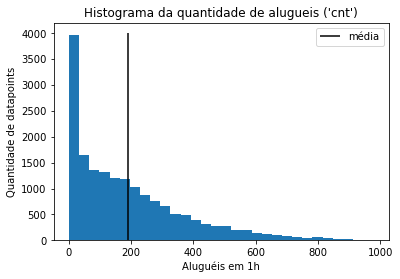

In [6]:
plt.hist(bike_rentals['cnt'],bins = 30)
plt.xlabel('Aluguéis em 1h')
plt.ylabel('Quantidade de datapoints')
plt.title("Histograma da quantidade de alugueis ('cnt')")
plt.vlines(bike_rentals['cnt'].mean(),0,4000,color = 'black',label = "média")
plt.legend()
plt.show()

* O histograma e análise dos quartis acima mostram que temos uma distribuição na quantidade de viagens muito assimétrica, com muitos pontos com poucas ou nenhuma viagem, e poucos pontos com muitas viagens.


* A média é de 189,46 viagens por hora

* Vemos que as colunas que possuem maior correlação com a quantidade de viagens são as colunas 'registered' e 'casual', seguidas pela temperatura e pela hora e umidade. As colunas 'registered' e 'casual' na verdade são o número de viagens de usuários registrados e de usuários que estão usando o serviço sem um registro, então faz sentido que elas tenham uma alta correlação (somadas as duas correspondem ao valor da coluna 'cnt').

## 4. Criando uma nova feature de faixa de horários (manhã, tarde, noite e madrugada):

* O nosso dataset possui uma coluna para as horas (coluna 'hr'). Ao utilizar essa coluna, nosso modelo vai interpretá-la como um valor numérico, sem distinguir os períodos de manhã, tarde, noite e madrugada.


* Com o intuito de fazer essa divisão, vamos criar uma nova coluna, 'time_label', com 4 faixas de hora.

In [7]:
def assign_label(h):
    if 6 <= h <12: #manhã
        return 1
    elif 12 <= h <18: #tarde
        return 2
    elif 18 <= h <24: #noite
        return 3
    elif 0 <= h < 6: #madrugada
        return 4
    else:
        return None

In [8]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## 5. Escolhendo e transformando as features

* Primeiramente ao escolher as features do nosso modelo, vemos que devemos desconsiderar as seguinte colunas:
  
     * Coluna **instant** pois é apenas um ID, e não uma característica do data point
     * Coluna **cnt** pois é justamente o valor que queremos prever ('target')
     * Colunas **registered** e **casual**, pois somadas as duas resultam na coluna 'cnt'
     * Coluna **dteday** pois ela "vazaria" informação sobre o dia que a bike foi alugada
     * Coluna **atemp** pois ela contém a mesma informação que a coluna **temp**


In [9]:
features = list(bike_rentals.columns)
features.remove('instant')
features.remove('dteday')
features.remove('registered')
features.remove('casual')
features.remove('atemp')
features.remove('cnt')

In [10]:
bike_rentals[features].dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
hum           float64
windspeed     float64
time_label      int64
dtype: object

In [11]:
bike_rentals[features].sample(3)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,time_label
11255,2,1,4,4,0,4,1,2,0.42,0.71,0.0000,4
11191,2,1,4,12,1,1,0,1,0.68,0.57,0.2537,2
2848,2,0,5,14,0,2,1,2,0.70,0.58,0.5224,2


* Vemos que as colunas **season**, **mnth**, **hr**, **weekday**, **weathersit** e **time_label**, devem ser consideradas como categóricas, e não como colunas numéricas, já que não existe uma relação de > ou < entre os diferentes números de cada coluna.


* Dessa forma, vamos tranformá-las em colunas categóricas e aplicar o processo de "dummy coding".

In [12]:
cat_cols = ['season','mnth','hr','weekday','weathersit','time_label']

for col in cat_cols: 
    bike_rentals[col] = bike_rentals[col].astype('category')

dummies = pd.get_dummies(bike_rentals[cat_cols])
bike_rentals = pd.concat([bike_rentals, dummies], axis = 1)
bike_rentals = bike_rentals.drop(columns = cat_cols)
bike_rentals.sample(5)

,instant,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,time_label_1,time_label_2,time_label_3,time_label_4
3077,3078,2011-05-13,0,0,1,0.50,0.4848,0.88,0.1343,2,2,4,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
13764,13765,2012-08-01,1,0,1,0.80,0.7424,0.49,0.1642,103,734,837,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
11415,11416,2012-04-25,1,0,1,0.56,0.5303,0.22,0.0896,22,358,380,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
14584,14585,2012-09-04,1,0,1,0.74,0.7121,0.74,0.2537,28,240,268,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
460,461,2011-01-21,0,0,1,0.24,0.1970,0.60,0.4179,1,4,5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1


In [13]:
for col in cat_cols:
    features.remove(col)
    
for col in dummies.columns:
    features.append(col)
    
for feat in features:
    print(feat, end = " / ")

yr / holiday / workingday / temp / hum / windspeed / season_1 / season_2 / season_3 / season_4 / mnth_1 / mnth_2 / mnth_3 / mnth_4 / mnth_5 / mnth_6 / mnth_7 / mnth_8 / mnth_9 / mnth_10 / mnth_11 / mnth_12 / hr_0 / hr_1 / hr_2 / hr_3 / hr_4 / hr_5 / hr_6 / hr_7 / hr_8 / hr_9 / hr_10 / hr_11 / hr_12 / hr_13 / hr_14 / hr_15 / hr_16 / hr_17 / hr_18 / hr_19 / hr_20 / hr_21 / hr_22 / hr_23 / weekday_0 / weekday_1 / weekday_2 / weekday_3 / weekday_4 / weekday_5 / weekday_6 / weathersit_1 / weathersit_2 / weathersit_3 / weathersit_4 / time_label_1 / time_label_2 / time_label_3 / time_label_4 / 

In [14]:
bike_rentals[features].sample(5)

,yr,holiday,workingday,temp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,time_label_1,time_label_2,time_label_3,time_label_4
9332,1,0,0,0.34,0.23,0.3582,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1878,0,0,1,0.30,1.00,0.2239,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
1156,0,0,0,0.30,0.61,0.1642,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2591,0,0,1,0.30,0.93,0.1642,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
11275,1,0,1,0.48,0.67,0.1045,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1


## 6. Dividindo o dataset em um subset de treino e de teste

* Vamos usar uma amostra aleatório corresponde a 80% dos datapoints para treino e 20% para teste.

In [23]:
train = bike_rentals.sample(frac = 0.8)
test = bike_rentals[~bike_rentals.index.isin(train.index)] #seleciona os índices que não estão no subset train

## 7. Aplicando um modelo de Regressão Linear

* Vamos começar testando um modelo de regressão linear.

* Vamos usar o root mean squared error (RMSE) como métrica para avaliar os modelos. O RMSE é uma métrica utilizada para valores contínuos, que é o nosso caso. A vantagem do RMSE em relação ao MSE (sem a raiz quadrada) é o fato de que o RMSE retorna um valor de erro na mesma unidade que estamos prevendo (enquanto o MSE retorna a unidade^2).
 

In [30]:
lr_model = LinearRegression()
lr_model.fit(train[features],train[['cnt']])
lr_prediction = lr_model.predict(test[features])
lr_rmse = mean_squared_error(test[['cnt']],lr_prediction)**0.5
print("Regressão Linear, TEST SET, RMSE = {}".format(round(lr_rmse,2)))

Regressão Linear, TEST SET, RMSE = 103.67


In [31]:
lr_predicticon_train = lr_model.predict(train[features])
lr_rmse_train = mean_squared_error(train[['cnt']],lr_predicticon_train)**0.5
print("Regressão Linear, TRAIN SET, RMSE = {}".format(round(lr_rmse_train,2)))

Regressão Linear, TRAIN SET, RMSE = 101.22


* O erro que encontramos é relativamente grande. Isso provavelmente se deve ao fato de termos poucos pontos com muito mais viagens (primeiras colunas no nosso histograma). Esses valores muito longe da média são mais "penalisados" no RMSE, já que essa métrica eleva o diferença entre o valor previsto e o real ao quadrado (o RMSE penalisa mais uma situação com "poucos erros muito grandes", do que uma situação com "muitos erros muito pequenos").


* Testamos também o modelo no próprio train set e o resultado foi muito parecido. O que indica que não estamos overfitting. Na verdade, estamos underfitting, pois estamos usando um modelo que não reproduz bem as cartacterísicas do nosso set.

## 8. Aplicando Decision Trees

* Vamos instanciar um modelo de regressãao com base em decision trees.


* Vamos alterar o parâmetro min_sample_leaf para 5, isso permite que após um split um subset com 5 linhas com o mesmo label já possa ser considerado uma "folha" (leaf, que são as extremidades da árvore de decisão"). Essa alteração, assim como a diminuição do parâmetro max_depth, contribui para reduzir a tendência a overfitting do modelo de decision tree.

In [34]:
dt_model = DecisionTreeRegressor(min_samples_leaf=5)
dt_model.fit(train[features],train[['cnt']])
dt_prediction = dt_model.predict(test[features])
dt_rmse = mean_squared_error(test['cnt'],dt_prediction)**0.5
print("Decision Tree, TEST SET, RMSE = {}".format(round(dt_rmse,2)))

Decision Tree, TEST SET, RMSE = 57.84


In [35]:
dt_prediction_train = dt_model.predict(train[features])
dt_rmse_train = mean_squared_error(train['cnt'],dt_prediction_train)**0.5
print("Decision Tree, TRAIN SET, RMSE = {}".format(round(dt_rmse_train,2)))

Decision Tree, TRAIN SET, RMSE = 37.16


* Com uma decision tree o erro reduziu bastante, se mostrando muito mais apropriado para prever a quantidade de bicicletas alugadas com base nas features que possuímos.


* No entanto vemos que nosso modelo está "overfitting", já que o erro quando rodamos o modelo no próprio trainning set está muito menor.


* Uma maneira de reduzir o overfitting, tendo como efeito colateral um aumento do erro total, seria alterando o parâmetro "splitter" para "random" ao invés de "best". Dessa forma, cada vez que o modelo precisa decidir qual feature usar para fazer a divisão da árvore, ele calcula o ganho de entropia dos novos subsets para uma sublista aleatória de features.

## 9. Aplicando Random Forest

* Ao invés de apenas mudar o parâmetro "splitter" da decision tree, vamos utilizar um modelo de random forest.

* A random forest, além avaliar features aleatórias antes de cada split, também incorpora o conceito de "bagging", que consiste em utilizar diferentes subsets menores do dataset total, e depois calcular a média entre eles (parâmetro "bootstrap" do RanfomForest, que é True por default), por isso ela tem uma tendência menor a "overfit".

In [39]:
rf_model = RandomForestRegressor(n_estimators = 20,min_samples_leaf=10)
rf_model.fit(train[features],train['cnt'])
rf_prediction = rf_model.predict(test[features])
rf_rmse = mean_squared_error(test[['cnt']],rf_prediction)**0.5
print("Random Forest, TEST SET, RMSE = {}".format(round(rf_rmse,2)))

Random Forest, TEST SET, RMSE = 55.48


In [40]:
rf_prediction_train = rf_model.predict(train[features])
rf_rmse_train = mean_squared_error(train[['cnt']],rf_prediction_train)**0.5
print("Random Forest, TRAIN SET, RMSE = {}".format(round(rf_rmse_train,2)))

Random Forest, TRAIN SET, RMSE = 46.76


* Como previsto, o modelo de random forest não só melhorou a precisão do modelo, como também reduziu o overfitting.

## 10. Desenhando a decision tree

* Uma vantagem da utilização das decisions trees em relação ao random forest é o fato de que com decision trees, conseguimos desenhar a árvore de decisão utilizada pelo modelo e entender melhor como ele faz suas estimativas.

* Abaixo vamos rodar um modelo de decision tree mais simples, com menos "camadas" (max_depth = 4) e plotar a árvore de decisão.

* Estamos fazendo isso apenas como um exercício, como vemos acima, o modelo que apresentou os melhores resultados foi a random forest.

In [46]:
dt_model = DecisionTreeRegressor(min_samples_leaf=5,max_depth = 4)
dt_model.fit(train[features],train[['cnt']])
dt_prediction = dt_model.predict(test[features])
dt_rmse = mean_squared_error(test['cnt'],dt_prediction)**0.5
dt_rmse

125.60714008541544

[Text(976.5, 1712.34, 'time_label_4 <= 0.5\nmse = 32674.648\nsamples = 13903\nvalue = 189.173'),
 Text(488.25, 1331.82, 'temp <= 0.47\nmse = 31356.758\nsamples = 10481\nvalue = 242.815'),
 Text(244.125, 951.3, 'yr <= 0.5\nmse = 17997.688\nsamples = 4651\nvalue = 165.747'),
 Text(122.0625, 570.78, 'season_4 <= 0.5\nmse = 8615.281\nsamples = 2368\nvalue = 119.411'),
 Text(61.03125, 190.26, 'mse = 4696.219\nsamples = 1588\nvalue = 94.054'),
 Text(183.09375, 190.26, 'mse = 12619.873\nsamples = 780\nvalue = 171.036'),
 Text(366.1875, 570.78, 'hr_8 <= 0.5\nmse = 23192.614\nsamples = 2283\nvalue = 213.808'),
 Text(305.15625, 190.26, 'mse = 17309.649\nsamples = 2138\nvalue = 199.391'),
 Text(427.21875, 190.26, 'mse = 61684.663\nsamples = 145\nvalue = 426.379'),
 Text(732.375, 951.3, 'hr_17 <= 0.5\nmse = 33495.808\nsamples = 5830\nvalue = 304.297'),
 Text(610.3125, 570.78, 'hr_18 <= 0.5\nmse = 28113.406\nsamples = 5471\nvalue = 286.985'),
 Text(549.28125, 190.26, 'mse = 23373.546\nsamples = 513

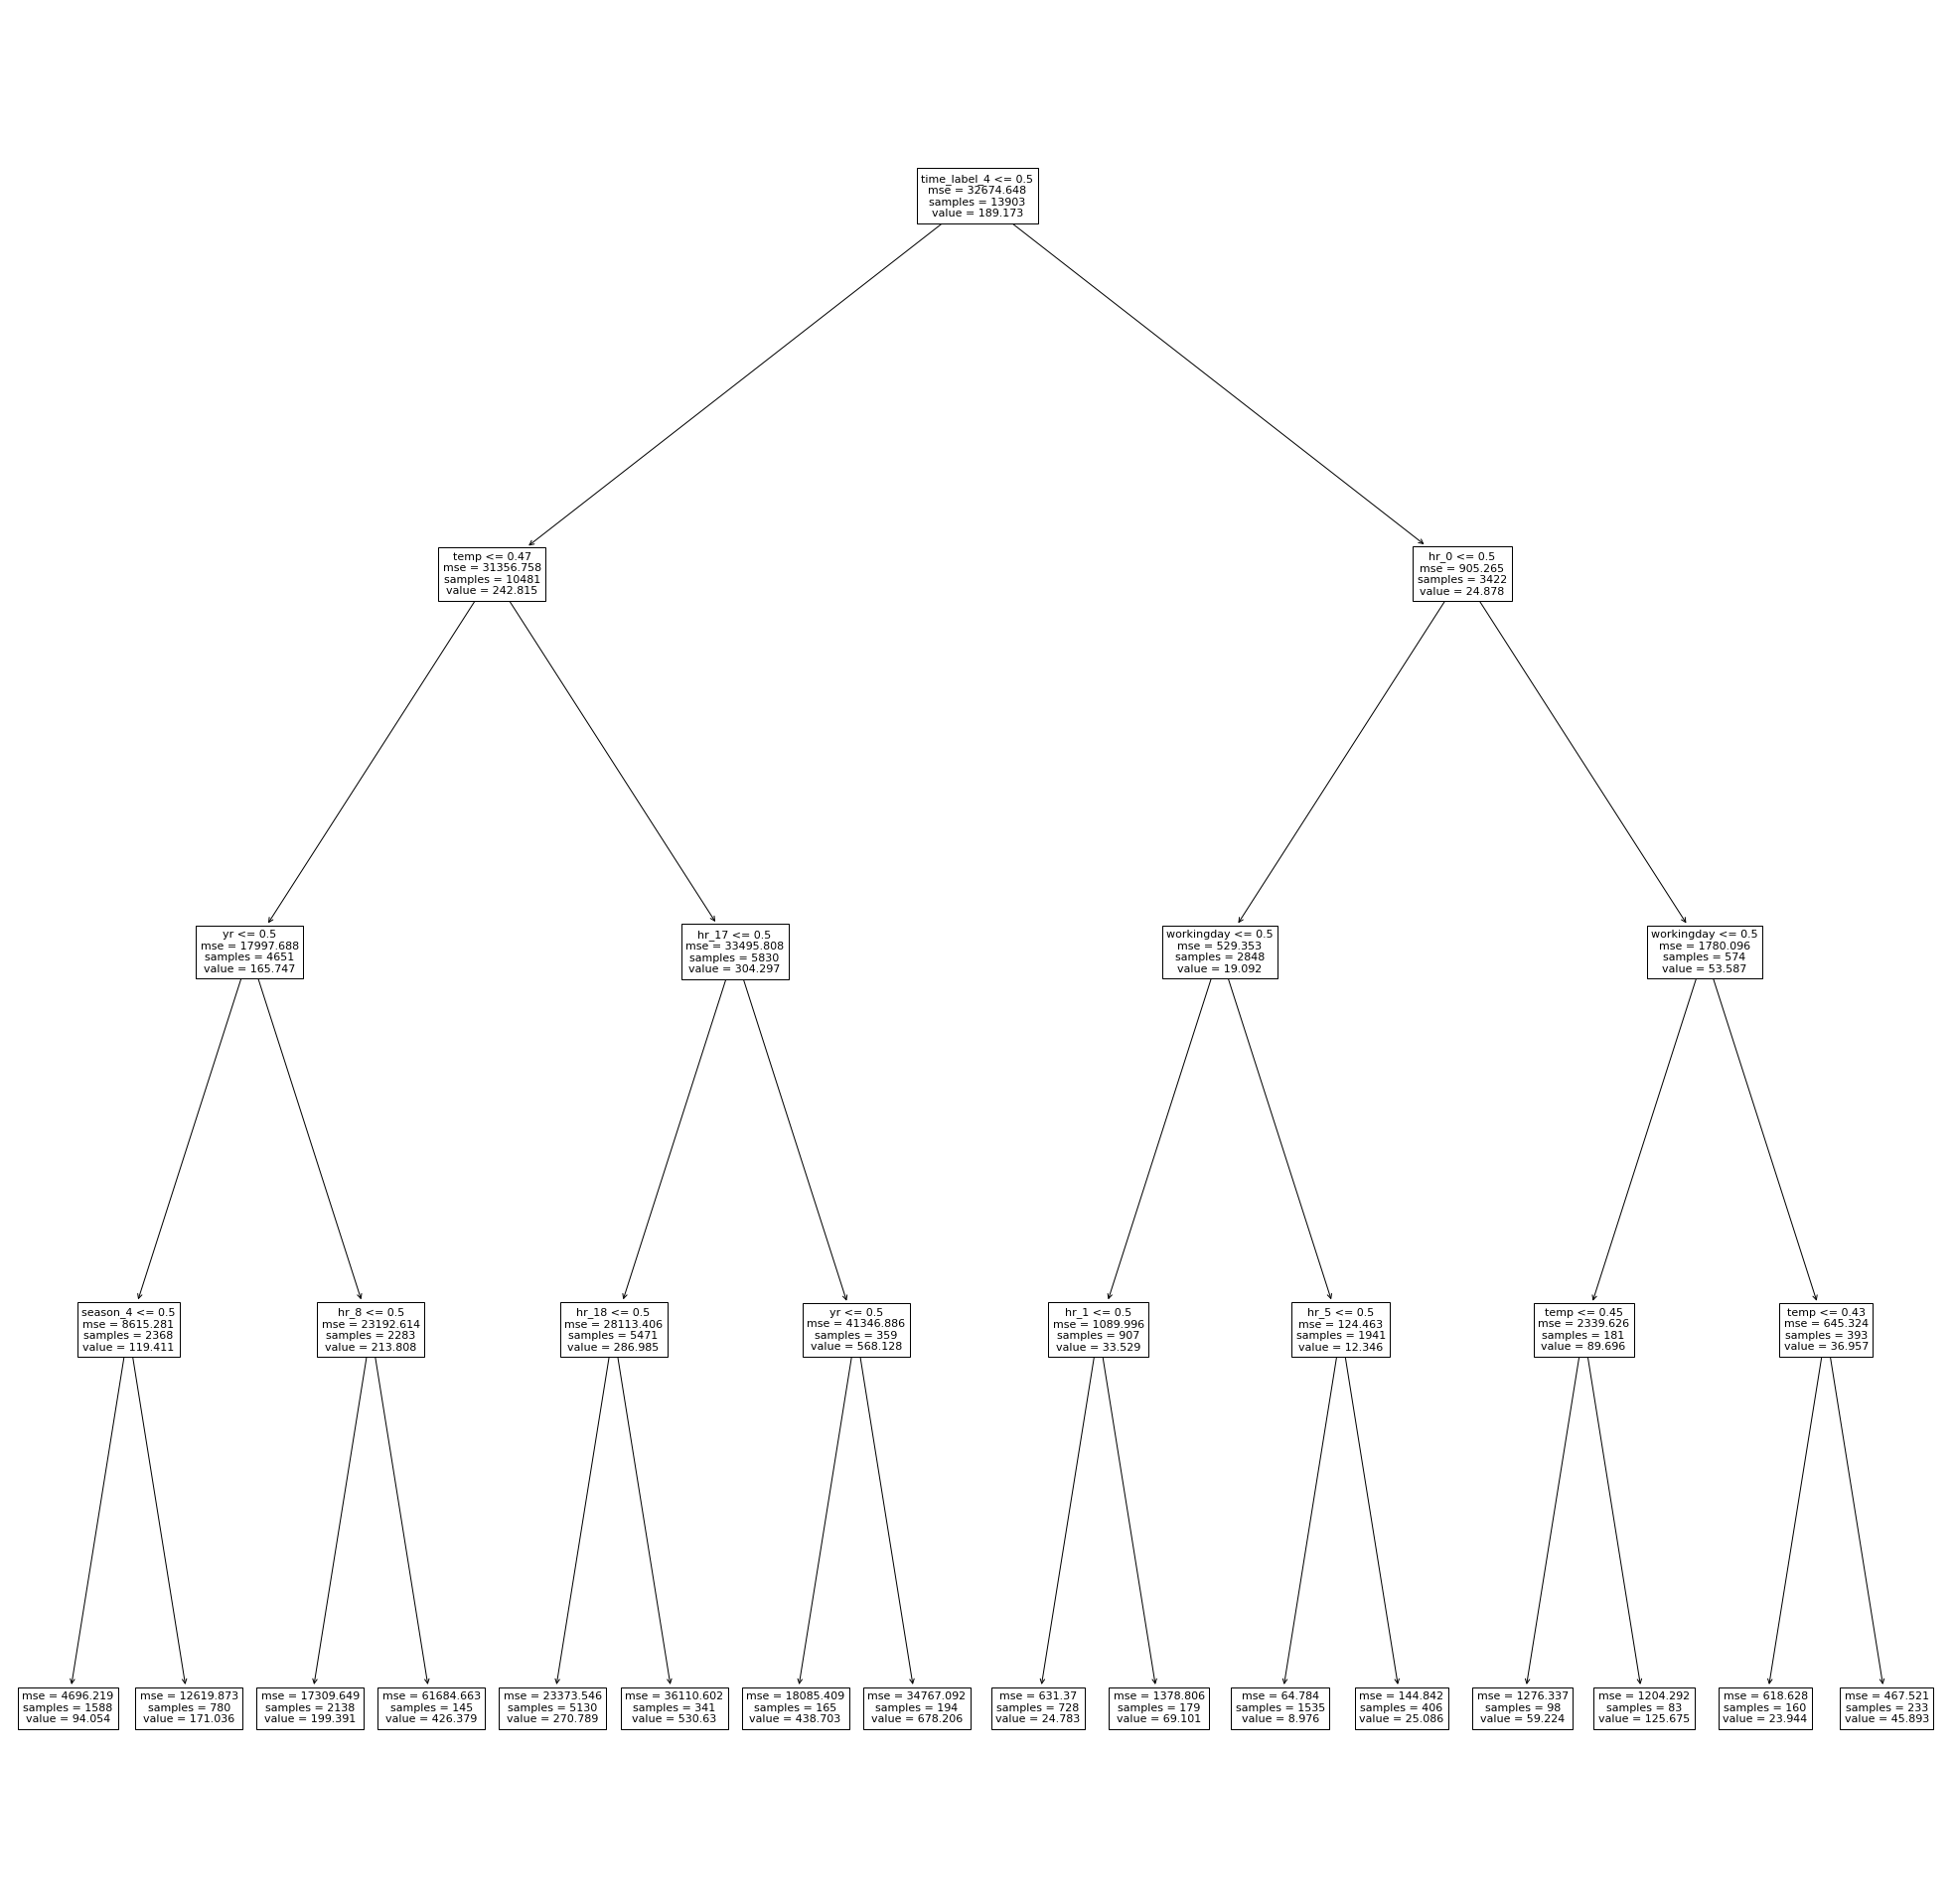

In [49]:
fig1 = plt.figure(figsize = (35,35))
ax1 = fig1.add_subplot()

plot_tree(dt_model, ax = ax1, feature_names = features)